## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd

## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/is-that-santa')

There are 1230 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

santa_count = len(list(data_dir.glob('santa/*')))
print(santa_count)

notSanta_count = len(list(data_dir.glob('not-a-santa/*')))
print(notSanta_count)

1230
615
615


### Target Distribution

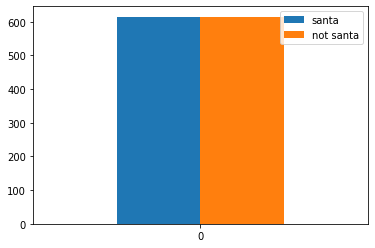

In [5]:
# Distribution
df = pd.DataFrame([(santa_count, notSanta_count)], columns=('santa', 'not santa'))

df.plot.bar(rot=0)

# It's even so it doesn't really matter


Here are some santas:

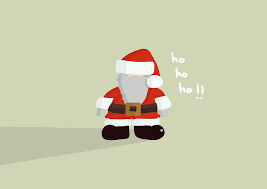

In [6]:
santa = list(data_dir.glob('santa/*'))
PIL.Image.open(str(santa[2]))

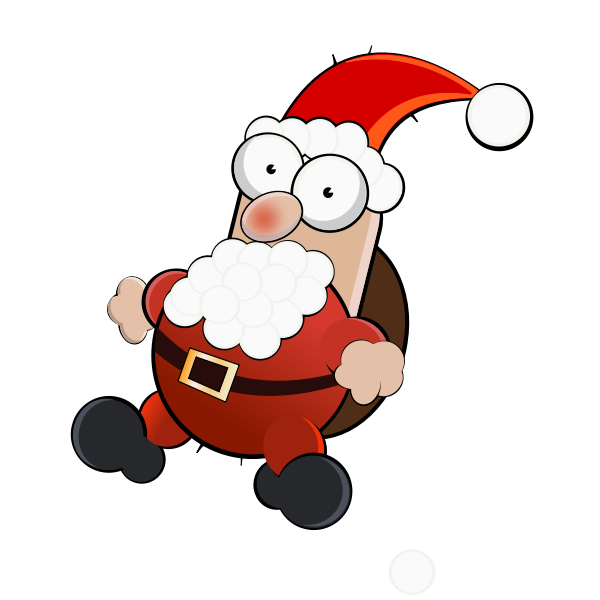

In [7]:
PIL.Image.open(str(santa[1]))

And some not santas:

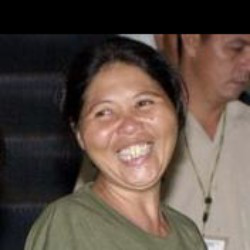

In [8]:
notSanta = list(data_dir.glob('not-a-santa/*'))
PIL.Image.open(str(notSanta[0]))

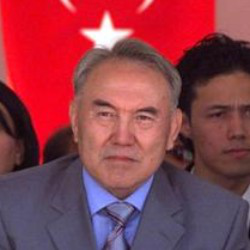

In [9]:
PIL.Image.open(str(notSanta[1]))

## Load data using a Keras utility

Load these images off disk using `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

### Train/Test Split

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1230 files belonging to 2 classes.
Using 984 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1230 files belonging to 2 classes.
Using 246 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['not-a-santa', 'santa']


## Visualize the data

Here are the first nine images from the training dataset:

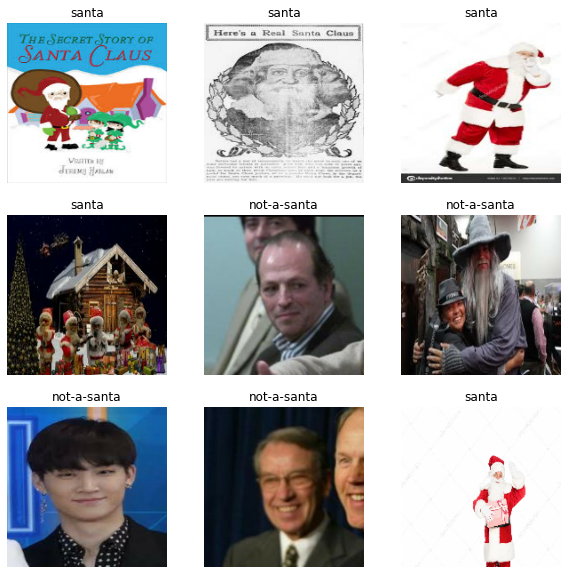

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Using `Dataset.cache` and `Dataset.prefetch`

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Standardize `[0, 255]` RGB values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

Apply to the dataset by calling `Dataset.map`:

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

## A Basic Keras Sequential Model

### Create the model

The Keras Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

Using the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function.

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View layers

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
31/31 [==============================] - 1s 27ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.5340 - val_accuracy: 0.9106
Epoch 2/10
31/31 [==============================] - 1s 24ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4327 - val_accuracy: 0.9187
Epoch 3/10
31/31 [==============================] - 1s 24ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5107 - val_accuracy: 0.9309
Epoch 4/10
31/31 [==============================] - 1s 24ms/step - loss: 8.1585e-04 - accuracy: 1.0000 - val_loss: 0.4780 - val_accuracy: 0.9187
Epoch 5/10
31/31 [==============================] - 1s 24ms/step - loss: 6.4522e-04 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.9309
Epoch 6/10
31/31 [==============================] - 1s 24ms/step - loss: 4.1402e-04 - accuracy: 1.0000 - val_loss: 0.5143 - val_accuracy: 0.9268
Epoch 7/10
31/31 [==============================] - 1s 23ms/step - loss: 3.4308e-04 - accuracy: 1.0000 - val_loss: 0.5296 - val_accuracy: 0.93

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

final training accuracy: 1.00
final validation accuracy: 0.93
final training loss: 0.00
final validation loss: 0.57


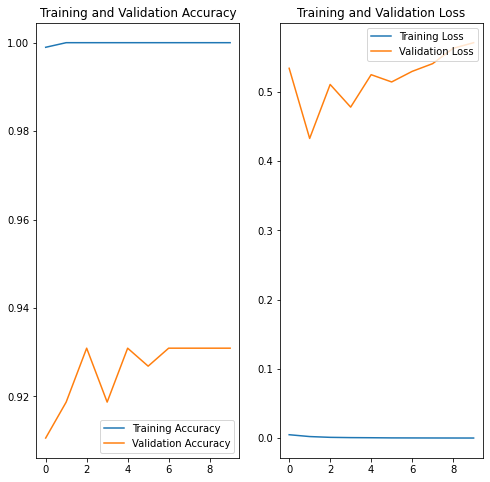

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("final training accuracy: {:.2f}".format(acc[-1]))

print("final validation accuracy: {:.2f}".format(val_acc[-1]))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("final training loss: {:.2f}".format(loss[-1]))
print("final validation loss: {:.2f}".format(val_loss[-1]))

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Some discrepancies between accuracies and losses

## Data augmentation to handle Overfitting (Adjusted CNN)




Generate additional data through transformations using `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. 

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Augmentation Examples:

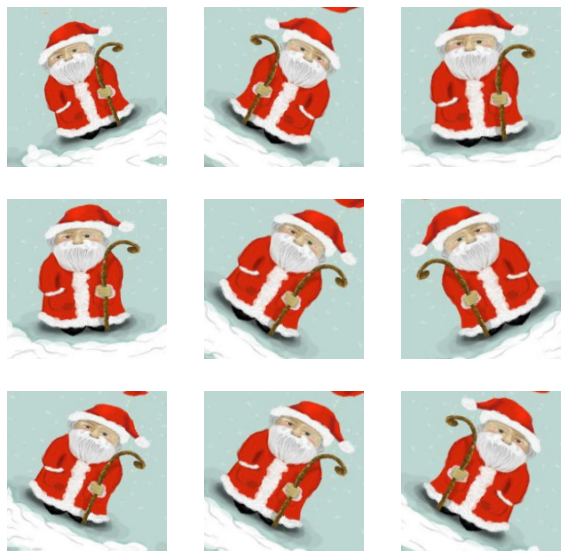

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Dropout Regularization

Create a new neural network with `tf.keras.layers.Dropout`

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
31/31 [==============================] - 2s 49ms/step - loss: 0.7438 - accuracy: 0.6348 - val_loss: 0.6925 - val_accuracy: 0.5691
Epoch 2/15
31/31 [==============================] - 1s 41ms/step - loss: 0.5240 - accuracy: 0.7357 - val_loss: 0.6032 - val_accuracy: 0.8049
Epoch 3/15
31/31 [==============================] - 1s 41ms/step - loss: 0.3898 - accuracy: 0.8231 - val_loss: 0.6636 - val_accuracy: 0.8252
Epoch 4/15
31/31 [==============================] - 1s 41ms/step - loss: 0.2965 - accuracy: 0.8824 - val_loss: 0.5220 - val_accuracy: 0.8415
Epoch 5/15
31/31 [==============================] - 1s 41ms/step - loss: 0.2682 - accuracy: 0.8835 - val_loss: 0.7121 - val_accuracy: 0.8130
Epoch 6/15
31/31 [==============================] - 1s 41ms/step - loss: 0.3198 - accuracy: 0.8647 - val_loss: 0.3597 - val_accuracy: 0.8496
Epoch 7/15
31/31 [==============================] - 1s 40ms/step - loss: 0.2789 - accuracy: 0.8845 - val_loss: 0.3815 - val_accuracy: 0.8577
Epoch 8/15
31

## Visualize training results

final training accuracy: 0.92
final validation accuracy: 0.86
final training loss: 0.20
final validation loss: 0.41


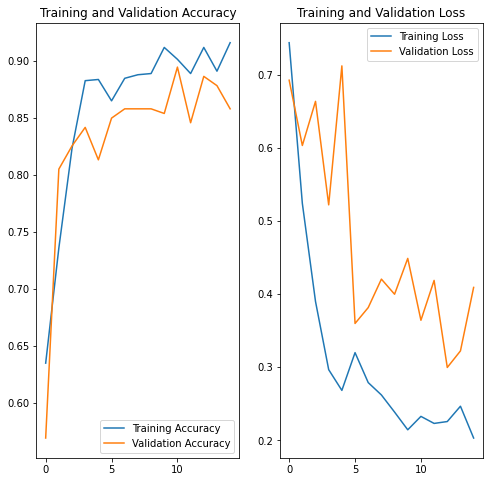

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("final training accuracy: {:.2f}".format(acc[-1]))
print("final validation accuracy: {:.2f}".format(val_acc[-1]))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("final training loss: {:.2f}".format(loss[-1]))
print("final validation loss: {:.2f}".format(val_loss[-1]))

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Transfer

## Data Pre-processing

In [32]:
BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_dataset = train_ds

validation_dataset = val_ds

## Rescale pixels

In [33]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create Base Model from MobileNet V2

In [34]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [35]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


### Freeze convolutional base

In [36]:
base_model.trainable = False

In [37]:
# Summary of Architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

### Add a Classification Head

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Convert features into a single prediction per image

In [39]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Build Model

In [40]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile Model

In [41]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

### Train the Model

In [43]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 3s 72ms/step - loss: 0.7739 - accuracy: 0.5610


In [44]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.56


In [45]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
31/31 [==============================] - 6s 98ms/step - loss: 0.7136 - accuracy: 0.5838 - val_loss: 0.6191 - val_accuracy: 0.6626
Epoch 2/10
31/31 [==============================] - 3s 90ms/step - loss: 0.6226 - accuracy: 0.6535 - val_loss: 0.5436 - val_accuracy: 0.7195
Epoch 3/10
31/31 [==============================] - 3s 91ms/step - loss: 0.5195 - accuracy: 0.7086 - val_loss: 0.4908 - val_accuracy: 0.7764
Epoch 4/10
31/31 [==============================] - 2s 55ms/step - loss: 0.4700 - accuracy: 0.7503 - val_loss: 0.4474 - val_accuracy: 0.7967
Epoch 5/10
31/31 [==============================] - 2s 55ms/step - loss: 0.4128 - accuracy: 0.7867 - val_loss: 0.4153 - val_accuracy: 0.8211
Epoch 6/10
31/31 [==============================] - 2s 55ms/step - loss: 0.3969 - accuracy: 0.8075 - val_loss: 0.3884 - val_accuracy: 0.8211
Epoch 7/10
31/31 [==============================] - 2s 55ms/step - loss: 0.3730 - accuracy: 0.8231 - val_loss: 0.3684 - val_accuracy: 0.8252
Epoch 8/10
31

## Visualize the Training Results

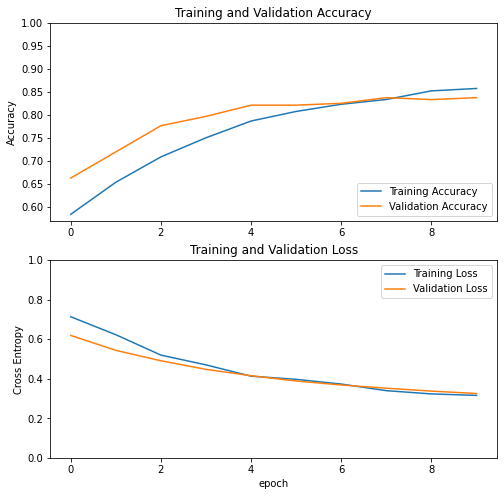

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("final training accuracy: {:.2f}".format(acc[-1]))
print("final validation accuracy: {:.2f}".format(val_acc[-1]))

loss = history.history['loss']
val_loss = history.history['val_loss']

print("final training loss: {:.2f}".format(loss[-1]))
print("final validation loss: {:.2f}".format(val_loss[-1]))

final training accuracy: 0.86
final validation accuracy: 0.84
final training loss: 0.32
final validation loss: 0.33


## Fine tuning

### Unfreeze Model

In [48]:
base_model.trainable = True

In [49]:
# Look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Recompile Model

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

In [52]:
len(model.trainable_variables)

56

## Retrain Model

In [53]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
31/31 [==============================] - 8s 97ms/step - loss: 0.2038 - accuracy: 0.9074 - val_loss: 0.1998 - val_accuracy: 0.9228
Epoch 11/20
31/31 [==============================] - 2s 67ms/step - loss: 0.1646 - accuracy: 0.9313 - val_loss: 0.1825 - val_accuracy: 0.9309
Epoch 12/20
31/31 [==============================] - 2s 69ms/step - loss: 0.1357 - accuracy: 0.9448 - val_loss: 0.1690 - val_accuracy: 0.9268
Epoch 13/20
31/31 [==============================] - 2s 81ms/step - loss: 0.1300 - accuracy: 0.9542 - val_loss: 0.1524 - val_accuracy: 0.9350
Epoch 14/20
31/31 [==============================] - 2s 73ms/step - loss: 0.1023 - accuracy: 0.9646 - val_loss: 0.1392 - val_accuracy: 0.9431
Epoch 15/20
31/31 [==============================] - 2s 68ms/step - loss: 0.0843 - accuracy: 0.9677 - val_loss: 0.1379 - val_accuracy: 0.9472
Epoch 16/20
31/31 [==============================] - 3s 92ms/step - loss: 0.0871 - accuracy: 0.9709 - val_loss: 0.1247 - val_accuracy: 0.9593
Epoch 

## Visualize the Results

In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

print("final training accuracy: {:.2f}".format(acc[-1]))
print("final validation accuracy: {:.2f}".format(val_acc[-1]))

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

print("final training loss: {:.2f}".format(loss[-1]))
print("final validation loss: {:.2f}".format(val_loss[-1]))

final training accuracy: 0.97
final validation accuracy: 0.96
final training loss: 0.06
final validation loss: 0.11


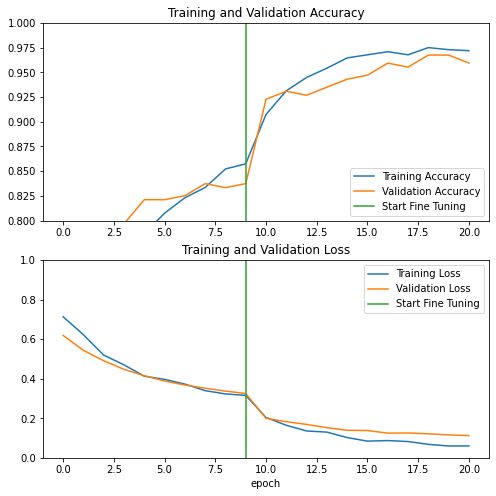

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Conclusions

I had 4 main approaches (4 models) that I worked with in this notebook. They were all sequential models and there was a regular CNN, a CNN with data augmentation, a model transfer, and model transfer with tuning.

The first CNN did amazingly well with the train set and managed to perfectly identify santa/not-santa. Even the validation accuracy of .93 was really impressive, but that tells me that this data was probably really easy to seperate.

The second CNN with data augmentation did worse when I ran it but the accuracy and loss graphs were much closer together than the first model. This could hopefully imply it could better generalize to other data it has yet to see.

The first model transfer did even poorer that the second CNN with its validation accuracy just trailing behind the second CNN. However, this was without any tuning.

The tuned model transfer did fantastic, even better than the first CNN when considering the validation accuracy of .96.


I assume these models did so well because the test data mostly consists of people or things that look like people. Given data that isn't similar to what I was using, I think the models would do significantly worse.